# Занятие 9: Изучение работы методов контроля температуры в молекулярной динамике

### Лев Мазаев, мАДМБ 18

Загрузим все необходимые библиотеки:

In [1]:
# Visualization
import nglview as nv
import mdtraj as mdt
from IPython.display import Video
from ipywidgets import VBox

# Working with Molecules
from rdkit import Chem
from rdkit.Chem import AllChem

# Plots
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# Performance estimation
import subprocess
import time
import pandas as pd

_ColormakerRegistry()

RDKit WARNING: [23:35:51] Enabling RDKit 2019.09.2 jupyter extensions


Версия с работающими виджетами [**здесь**](https://nbviewer.jupyter.org/github/Leoberium/SBDD/blob/master/9%20-%20Temperature%20in%20Molecular%20Dynamics/task9.ipynb).

### 1. Подготовка файла координат и файла топологии

Скачаем файл координат:

In [2]:
%%bash
wget -q -nc http://kodomo.fbb.msu.ru/FBB/year_08/term6/etane.gro
mv etane.gro et.gro

У нас есть шаблон файла топологии:

```
#include "/usr/share/gromacs/top/oplsaa.ff/forcefield.itp" 

[ moleculetype ]
; Name            nrexcl
et            3

[ atoms ]
;   nr  type  resnr  residue  atom   cgnr     charge       mass
    1   CX      1    ETH      C1      1    -0.189      12.01
    2   CX      1    ETH      C2      2    -0.155      12.01
    3   HX      1    ETH      H1      3     0.0059       1.008
    4   HX      1    ETH      H2      4     0.0059       1.008
    5   HX      1    ETH      H3      5     0.0059       1.008
    6   HX      1    ETH      H4      6     0.0056       1.008
    7   HX      1    ETH      H5      7     0.0056       1.008
    8   HX      1    ETH      H6      8     0.0056       1.008

[ bonds ]
;  ai    aj funct  b0       kb
     1   2   1  
     1   3   1
     1   4   1  
     1   5   1  
........... 
надо дописать

[ angles ]
;  ai    aj    ak funct  phi0   kphi
;around c1
    3     1     4     1  
    4     1     5     1  
    3     1     5     1  
    2     1     3     1  
    2     1     4     1  
    2     1     5     1  
;around c2
........... 
надо дописать 

[ dihedrals ]
;  ai    aj    ak    al funct  
    3    1     2     6      1  
    3    1     2     7      1 
    3    1     2     8      1  
    4    1     2     6      1  
 ........... 
надо дописать 

[ pairs ]
; список атомов 1-4
;  ai    aj funct
   3  6
   3  7
   3  8
   4  6
   4  7
   4  8
   5  6
   5  7
   5  8

[ System ]
; any text here
first one
[ molecules ]
;Name count
 et    1
```

Нужно его дополнить, чтобы получить правильный файл. В пакете gromacs последней версии есть функция [x2top](http://manual.gromacs.org/documentation/5.1.1/onlinehelp/gmx-x2top.html), которая генерирует примитивный файл топологии на основе структуры. Можно этим воспользоваться:

```bash
gmx x2top -f et.gro -o preet.top -ff oplsaa
```

In [3]:
! cat preet.top

;
;	File 'preet.top' was generated
;	By user: leo (1000)
;	On host: MS7922
;	At date: Tue Dec 17 19:31:21 2019
;
;	This is a include topology file
;
;	Created by:
;	                     :-) GROMACS - gmx x2top, 2019.4 (-:
;	
;	Executable:   /usr/local/gromacs/bin/gmx
;	Data prefix:  /usr/local/gromacs
;	Working dir:  /home/leo/ME/HSE/Chem/9 - Temperature in Molecular Dynamics
;	Command line:
;	  gmx x2top -f et.gro -o preet.top -ff oplsaa
;	Force field was read from the standard GROMACS share directory.
;

; Include forcefield parameters
#include "oplsaa.ff/forcefield.itp"

[ moleculetype ]
; Name            nrexcl
ICE                 3

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
     1   opls_157      1    ETH     C1      1      -0.18     12.011
     2   opls_157      1    ETH     C2      1      -0.18     12.011
     3   opls_140      1    ETH     H1      1       0.06      1.008
     4   opls_140      1    ETH     H2     

Типы атомов в oplsaa.ff: атомы opls с 135 по 140 - специально для алканов (т. е. и этана). То есть для водорода `x2top` предложила правильный тип **opls_140 - alkane H**, а вот для углерода - **opls_157 - all-atom C: CH3 & CH2, alcohols**. Судя по тому, что указано в файлах, этот тип атома имеет такие же параметры, как и **opls_135 - alkane CH3**, так что оставим **opls_157**.

Также нам нужно дописать углы и связи в исходной топологии, в чем нам поможет результат `x2top`. Для начала визуализируем этан:

In [4]:
ethane = Chem.MolFromSmiles('CC')
ethane.Compute2DCoords()
ethane = Chem.AddHs(ethane)
AllChem.EmbedMolecule(ethane)
AllChem.MMFFOptimizeMolecule(ethane, maxIters=500, nonBondedThresh=200)
v1 = nv.show_rdkit(ethane)
v1

NGLWidget()

Теперь представим окончательный файл топологии:

In [5]:
%%bash
echo '; Include forcefield parameters
#include "oplsaa.ff/forcefield.itp"

[ moleculetype ]
; Name    nrexcl
et        3

[ atoms ]
;  nr        type  resnr  residue  atom  cgnr    charge    mass
    1    opls_157      1      ETH    C1     1    -0.189   12.01
    2    opls_157      1      ETH    C2     2    -0.155   12.01
    3    opls_140      1      ETH    H1     3    0.0059   1.008
    4    opls_140      1      ETH    H2     4    0.0059   1.008
    5    opls_140      1      ETH    H3     5    0.0059   1.008
    6    opls_140      1      ETH    H4     6    0.0056   1.008
    7    opls_140      1      ETH    H5     7    0.0056   1.008
    8    opls_140      1      ETH    H6     8    0.0056   1.008

[ bonds ]
;   ai  aj funct  b0       kb
     1   2     1  
     1   3     1
     1   4     1  
     1   5     1
     2   6     1
     2   7     1
     2   8     1
     
[ angles ]
;  ai    aj    ak funct  phi0   kphi
;around c1
    2     1     3     1  
    2     1     4     1  
    2     1     5     1  
    3     1     4     1  
    3     1     5     1  
    4     1     5     1
;around c2
    1     2     6     1
    1     2     7     1
    1     2     8     1
    6     2     7     1
    6     2     8     1
    7     2     8     1
    
[ dihedrals ]
;  ai    aj    ak    al funct
    3     1     2     6     3
    3     1     2     7     3
    3     1     2     8     3
    4     1     2     6     3
    4     1     2     7     3
    4     1     2     8     3
    5     1     2     6     3
    5     1     2     7     3
    5     1     2     8     3
    
[ pairs ]
;  ai    aj funct
    3     6     1 
    3     7     1 
    3     8     1 
    4     6     1 
    4     7     1 
    4     8     1 
    5     6     1 
    5     7     1 
    5     8     1
    
[ system ]
; Name
et

[ molecules ]
; Compound        #mols
et                1' > et.top

### 2. Моделирование

Скачаем следующие файлы с параметрами контроля температуры:
- **be.mdp** - метод Берендсена для контроля температуры
- **vr.mdp** - метод "Velocity rescale" для контроля температуры
- **nh.mdp** - метод Нуза-Хувера для контроля температуры
- **an.mdp** - метод Андерсена для контроля температуры
- **sd.mdp** - метод стохастической молекулярной динамики

In [6]:
%%bash
echo 'http://kodomo.fbb.msu.ru/FBB/year_08/term6/be.mdp
http://kodomo.fbb.msu.ru/FBB/year_08/term6/vr.mdp
http://kodomo.fbb.msu.ru/FBB/year_08/term6/nh.mdp
http://kodomo.fbb.msu.ru/FBB/year_08/term6/an.mdp
http://kodomo.fbb.msu.ru/FBB/year_08/term6/sd.mdp' > urls.txt
wget -q -nc -i urls.txt -P mdp

Теперь создадим входные файлы для молекулярно-динамического движка mdrun с помощью grompp. При этом будем использовать gromacs, установленный на shadbox, так как те версии, что установлены локально, выдают следующую ошибку:

>ERROR 1 [file an.mdp]:
  Andersen temperature control not supported for integrator md.
  
```bash
for s in $(echo an be nh sd vr)
do
    grompp -f $s.mdp -c et.gro -p et.top -o et_$s.tpr
done
```

Здесь и далее буду использовать локальный gromacs версии 4.6.5, установленный с помощью conda. Скачаем tpr-файлы и запустим моделирование:

```bash
for s in `ls -1 ./tpr`
do
    mdrun -deffnm ./tpr/$s -nt 8 -v -o ./trr/$s
done
```

В каждом из случаев количество шагов моделирования - 250000 с шагом в 1 фемтосекунду, то есть всего 250 пикосекунд поведения системы. 

### 3. Визуальный анализ 

Создадим pdb-траекторию для каждого из файлов:

```bash
for s in $(echo an be nh sd vr)
do
    trjconv -f ./trr/et_$s.tpr.trr -s ./tpr/et_$s.tpr -o ./pdb/et_$s.pdb
done
```

И визуализируем с помощью `nglview`:

In [7]:
models = []

for s in ('an', 'be', 'nh', 'sd', 'vr'):
    md = mdt.load_pdb(f'./pdb/et_{s}.pdb')
    v = nv.show_mdtraj(md)
    models.append(v)
    
v2 = VBox(models)
v2

Как видим, в каждом из случаев молекула ведёт себя по-разному:
- Метод Андерсена: происходит лишь растяжение-сжатие химических связей
- Метод Берендсена: изменение длин связей, вращение молекулы вокруг C-C связи и вращение вокруг оси, направленной перпендикулярно связи C-C
- Метод Нуза-Хувера: изменение длин связей, вращение концов молекулы вокруг С-С связи с разной скоростью
- Метод стохастической МД: аналогично методу Берендсена + вращение молекулы не вокруг оси связи более сложное и заметно перемещение молекулы относительно начального положения
- Метод Velocity Rescale: аналогично методу Нуза-Хувера + небольшое вращение молекулы не вокруг оси связи

В HTML версии представленная выше визуализация не имеет смысла, так как траектории невозможно посмотреть. Поэтому были сделаны ролики в PyMOL для каждого из случаев, изображено 250 пикосекунд поведения системы. Метод Андерсена:

In [8]:
Video('./mov/et_an.mp4', embed=True)

Метод Берендсена:

In [9]:
Video('./mov/et_be.mp4', embed=True)

Метод Нуза-Хувера:

In [10]:
Video('./mov/et_nh.mp4', embed=True)

Метод стохастической молекулярной динамики:

In [11]:
Video('./mov/et_sd.mp4', embed=True)

Метод Velocity Rescale:

In [12]:
Video('./mov/et_vr.mp4', embed=True)

Ролики создавались с помощью команд в PyMOL:

```
bg_color white
orient
set ray_trace_frames, 1
set antialias, 2
mpng ./mov/frm
```

И затем ffmpeg:

```bash
ffmpeg -r 10 -i frm%04d.png -c:v libx264 -vf "fps=30,format=yuv420p" et_an.mp4
```

### 4. Анализ параметров систем

Посчитаем потенциальную и кинетическую энергию для каждой из 5 систем:

```bash
for s in $(echo an be nh sd vr)
do
    g_energy -f ./tpr/et_$s.tpr.edr -o ./xvg_en/et_$i.xvg;
done
```

Программа каждый раз спрашивает какой тип вывода выбрать - выбираем Potential и Kinetic-En. Загрузим данные и напишем функцию для построения графиков:

In [13]:
en_data = {s: np.loadtxt(fname=f'./xvg_en/et_{s}.xvg', comments=['#', '@']) for s in ('an', 'be', 'nh', 'sd', 'vr')}

In [14]:
names = {
    'an': 'Andersen',
    'be': 'Berendsen',
    'nh': 'Nosé–Hoover',
    'sd': 'Stochastic MD',
    'vr': 'Velocity Rescale'
}


def plotter(data, y_label, title,  col):
    fig, ax = plt.subplots(1, 5, figsize=(20, 6))
    
    i = 0
    for key, m in data.items():
        ax[i].plot(m[:, 0], m[:, col], f'C{i}')
        ax[i].set_title(names[key])
        ax[i].set_xlabel('Time (ps)')
        ax[i].set_ylabel(y_label)
        i += 1
    
    fig.subplots_adjust(wspace=0.25)
    fig.suptitle(title)
    plt.show()

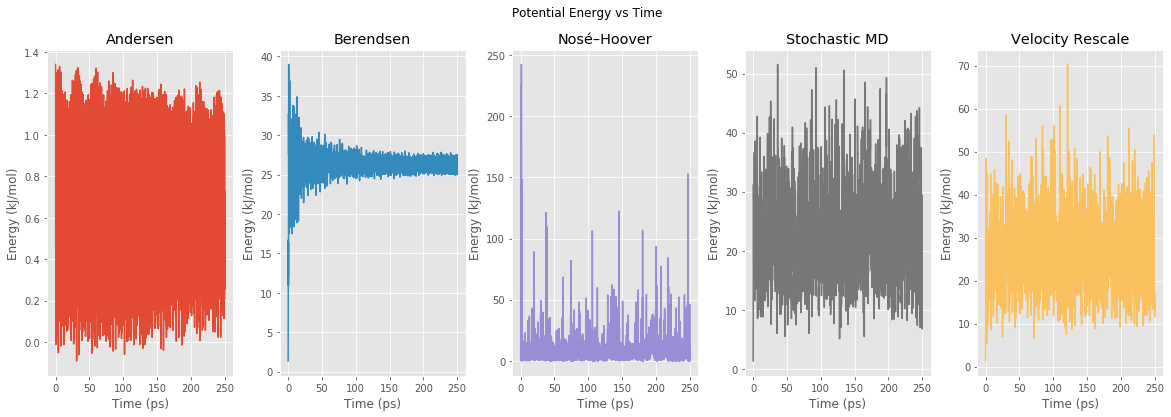

In [15]:
plotter(data=en_data, y_label='Energy (kJ/mol)', title='Potential Energy vs Time', col=1)

Видим, что графики потенциальной энергии ведут себя очень по разному, за исключением может быть методов стохастической МД и Velocity Rescale - их графики достаточно похожи.

Кинетическая энергия:

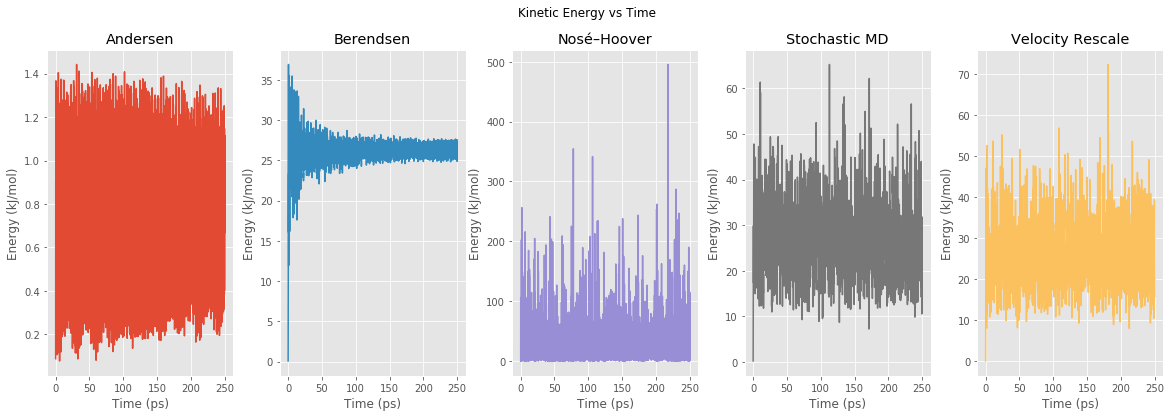

In [16]:
plotter(data=en_data, y_label='Energy (kJ/mol)', title='Kinetic Energy vs Time', col=2)

Графики по поведению аналогичны тому, что получилось с потенциальной энергией, только у метода Нуза-Хувера увеличился разброс значений и их средняя величина. Неплохо будет также построить гистограммы наблюдаемых значений энергий, чтобы увидеть формы распределений.

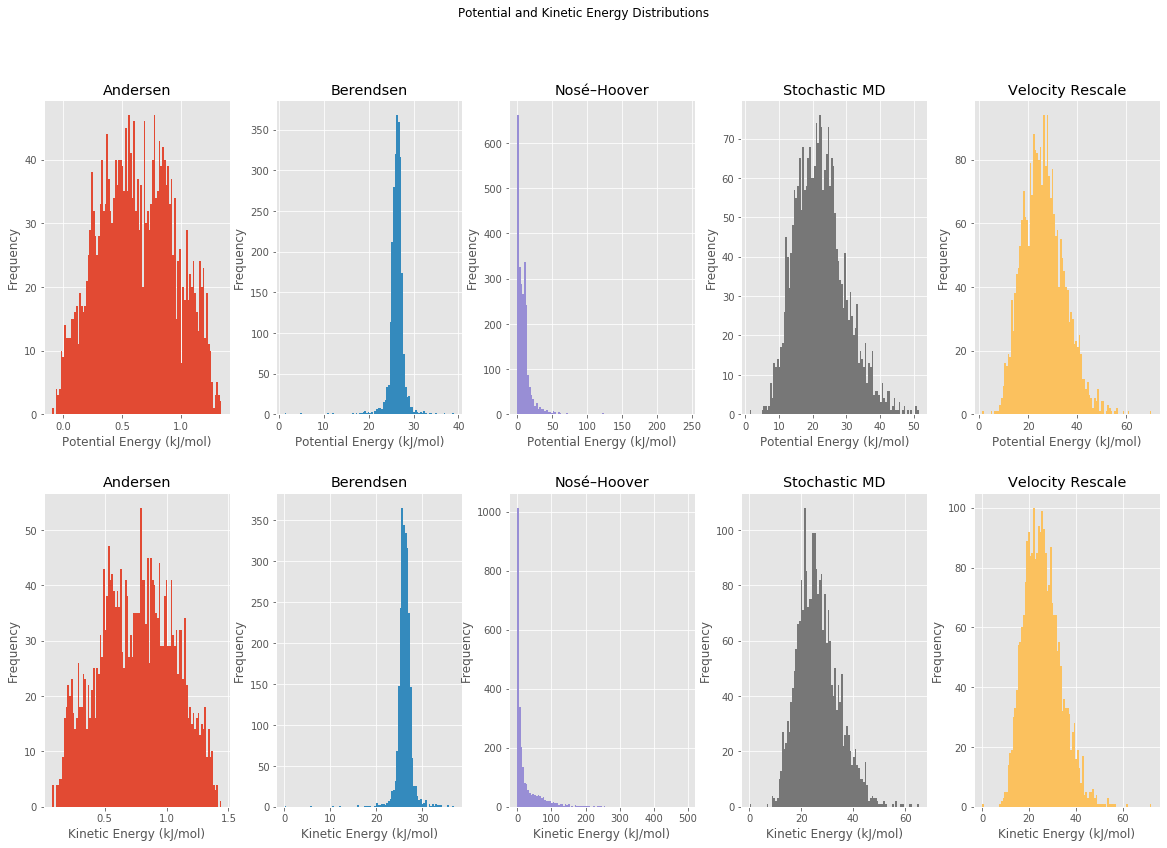

In [17]:
fig, ax = plt.subplots(2, 5, figsize=(20, 13))
    
i = 0
for key, m in en_data.items():
    ax[0][i].hist(m[:, 1], 100, color=f'C{i}')
    ax[0][i].set_title(names[key])
    ax[0][i].set_xlabel('Potential Energy (kJ/mol)')
    ax[0][i].set_ylabel('Frequency')
    i += 1
    
i = 0
for key, m in en_data.items():
    ax[1][i].hist(m[:, 2], 100, color=f'C{i}')
    ax[1][i].set_title(names[key])
    ax[1][i].set_xlabel('Kinetic Energy (kJ/mol)')
    ax[1][i].set_ylabel('Frequency')
    i += 1
    
fig.subplots_adjust(wspace=0.25, hspace=0.25)
fig.suptitle('Potential and Kinetic Energy Distributions')
plt.show()

По полученным графикам можно сказать, что "реалистичные" методы - метод стохастической молекулярной динамики и Velocity Rescale, так как распределение энергий каждого из них наиболее близко к Больцмановскому. Метод Нуза-Хувера даёт очень узкое распределение с высоким пиком, распределение двух оставшихся методов ещё более непохоже на Больцмановское.

Теперь посчитаем как менялась длина C-C связи в ходе моделирования:

```bash
for s in $(echo an be nh sd vr)
do
    g_bond -f ./trr/et_$s.tpr.trr -s ./tpr/et_$s.tpr -o ./xvg_bond/et_$s.xvg \
    -d ./xvg_bond/dist_et_$s.xvg -n b.ndx
done
```

Построим зависимость длины связи от времени для каждого из методов:

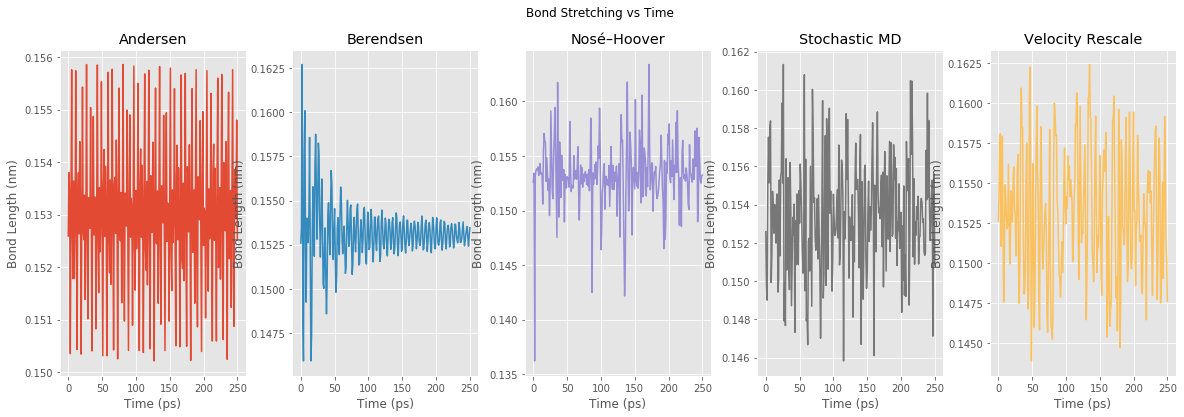

In [18]:
bl_data = {s: np.loadtxt(fname=f'./xvg_bond/dist_et_{s}.xvg', comments=['#', '@']) for s in ('an', 'be', 'nh', 'sd', 'vr')}
plotter(data=bl_data, y_label='Bond Length (nm)', title='Bond Stretching vs Time', col=1)

Всё так же, как было с энергией: все методы дают разный результат, но стохастический МД и Velocity Rescale ведут себя похоже.

Теперь распределение длин связей в ходе моделирования:

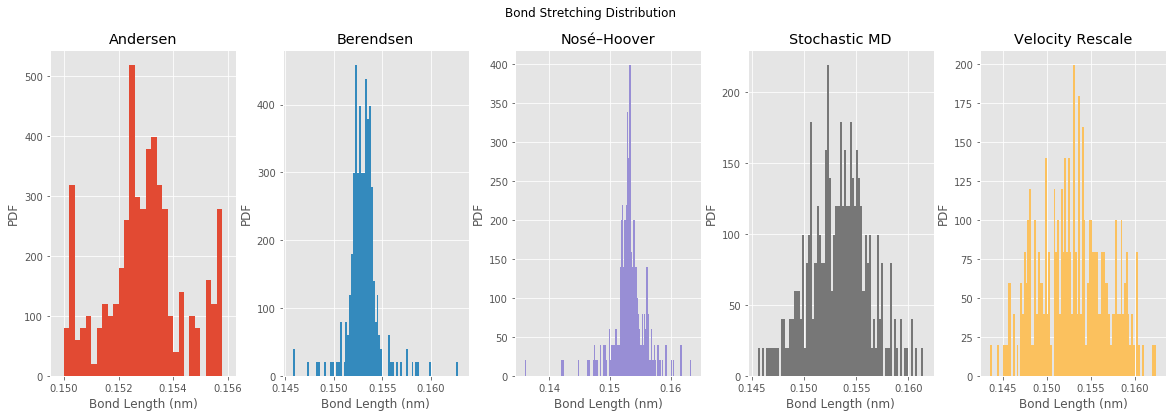

In [19]:
b_data = {s: np.loadtxt(fname=f'./xvg_bond/et_{s}.xvg', comments=['#', '@']) for s in ('an', 'be', 'nh', 'sd', 'vr')}

fig, ax = plt.subplots(1, 5, figsize=(20, 6))
    
i = 0
for key, m in b_data.items():
    ax[i].bar(x=m[:, 0], height=m[:, 1], width=-0.0002, align='edge', color=f'C{i}')
    ax[i].set_title(names[key])
    ax[i].set_xlabel('Bond Length (nm)')
    ax[i].set_ylabel('PDF')
    i += 1
    
fig.subplots_adjust(wspace=0.25)
fig.suptitle('Bond Stretching Distribution')
plt.show()

Если длина связи пропорциональна энергии, то опять же согласно распределениям методы стохастического МД и Velocity Rescale оказываются наиболее "реалистичны".

### 5. Оценка времени работы каждого из методов

Оценим время работы каждого из методов как среднее по 100 запускам:

In [20]:
times = {key: np.ones(100) for key in names}

for key in times.keys():
    for i in range(100):
        start = time.time()
        subprocess.call(f'mdrun -deffnm ./test/et_{key}.tpr 2> /dev/null', shell=True)
        times[key][i] = time.time() - start    

In [21]:
pd.DataFrame({
    'Method': [names[key] for key in times],
    'Time (s)': [round(times[key].mean(), 3) for key in times]
})

,Method,Time (s)
0,Andersen,1.100
1,Berendsen,1.107
2,Nosé–Hoover,1.154
3,Stochastic MD,1.428
4,Velocity Rescale,1.130


Как видим, все методы по скорости примерно одинаковы за исключением стохастического МД, он несколько медленнее.